# CartPole

In [2]:
import gym
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from collections import deque
import numpy as np
import random
from tqdm import tqdm  # shows where we are through training
import matplotlib.pyplot as plt   # to show off results
from scipy.stats import sem   # to show off confidence intervals
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import pylab as pl
import time

MountainCar gives the position and velocity in the range $\left[ -1.2, 0.6 \right] \times\left[ -0.07, 0.07 \right]$.

In [3]:
env_name = "CartPole-v1"
env = gym.make(env_name)

discount = 0.99 # discount factor (want it high because we only care about the end)
learning_rate = 0.0005  # learning rate   # 0.0005 gets -101
batch_size = 32   # how many experiences to train on at once
memory_length = 20000   # 20000 gets -101

state_size = env.observation_space.shape[0]   # state dimension
action_size = env.action_space.n   # 0, 1, or 2

num_trials = 1500   # 1200 gets -101
test_freq = 25   # after how many trials do we want to look at results?
num_tests = 40    # how many tests in each test
rendered_tests = 5   # how many rendered tests at the end?
extra_tests = 400   # at the end, how many additional tests do we want to do that are not rendered?
prec = 3   # precision when printing results

epsilon = 1  # start by moving randomly
epsilon_min = .005  # minimum epsilon
epsilon_episodes = int(num_trials/2)  # after this many episodes, have epsilon_min

In [4]:
# https://github.com/pythonlessons/Reinforcement_Learning/blob/master/05_CartPole-reinforcement-learning_PER_D3QN/PER.py
class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    # Here we define function that will add our priority score in the sumtree leaf and add the experience in data:
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0
            
    # Update the leaf priority score and propagate the change through tree
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop in the reference code
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    # Here build a function to get a leaf from our tree. So we'll build a function to get the leaf_index, priority value of that leaf and experience associated with that leaf index:
    def get_leaf(self, v):
        parent_index = 0

        # the while loop is faster than the method in the reference code
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

# Now we finished constructing our SumTree object, next we'll build a memory object.
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.8  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.5  # importance-sampling, from initial value increasing to 1

    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 2  # clipped abs error

    def __init__(self, env, capacity, amount_filled=1):
        # Making the tree 
        self.tree = SumTree(capacity)
        step = 0
        while step < int(capacity*amount_filled):   # only fill to approximately half (by default)
            s = env.reset()
            done = False
            while not done:
                a = env.action_space.sample()
                s1, r, done, info = env.step(a)
                self.remember([s,a,r,s1,done])
                s = s1
                step += 1
        env.close()
        
    # Next, we define a function to store a new experience in our tree.
    # Each new experience will have a score of max_prority (it will be then improved when we use this exp to train our DDQN).
    def remember(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
        
    # Now we create sample function, which will be used to pick batch from our tree memory, which will be used to train our model.
    # - First, we sample a minibatch of n size, the range [0, priority_total] into priority ranges.
    # - Then a value is uniformly sampled from each range.
    # - Then we search in the sumtree, for the experience where priority score correspond to sample values are retrieved from.
    def sample(self, n=batch_size):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i]= index

            minibatch.append([data[0],data[1],data[2],data[3],data[4]])

        return b_idx, minibatch
    
    # Update the priorities on the tree
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

memory = Memory(env, memory_length, 0.1)

In [5]:
# Train our neural network
def train(DQN):
    tree_idx, batch = memory.sample()
    s_mb = np.array([each[0].reshape(env.observation_space.shape[0],) for each in batch])
#     s_mb = s_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    a_mb = np.array([each[1] for each in batch])
    r_mb = np.array([each[2] for each in batch])
    s1_mb = np.array([each[3].reshape(env.observation_space.shape[0],) for each in batch])
#     s1_mb = s1_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    done_mb = np.array([each[4] for each in batch])
    
    # Get future Q values
    future_Qs = target_DQN.predict(s1_mb)[0]  # fixed Q targets
# was   future_Qs = DQN.predict(s1_mb)
    output = DQN.predict(s_mb)
    targets_mb = output[0].copy()
    state_pred = output[1].copy()
    targets_old = output[0].copy()   # PER
    del output
    for i in range(len(batch)):     # r if done, r+discount*Q(s') else
        terminal = done_mb[i]
        a = a_mb[i]

        if terminal:
          target = r_mb[i]
        else:
          target = r_mb[i] + discount*future_Qs[i][np.argmax(targets_mb[i])]   # Double DQN
#    was  target = r_mb[i] + discount*np.max(future_Qs[i])   # Double DQN

        targets_mb[i][a] = target
    targets_mb = np.array(targets_mb)
    target_diff_prios = np.sum(np.abs(targets_old-targets_mb), axis=1)  # PER
    pred_prios = np.sum(np.abs(state_pred-s1_mb), axis=1)
    memory.batch_update(tree_idx, target_diff_prios + pred_prios)  # PER
    
    hist = DQN.fit(s_mb, [targets_mb, s1_mb], epochs=1, verbose=False, batch_size = batch_size)
    loss = hist.history['loss'][0]

    return loss


# A function to select an action based on the current Q table and epsilon

def select_action(state):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    action_probs, critic_value = model(state)
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))
    return action, action_probs, critic_value



# Test current Q_table

def tester(env):
    test_list = []
    for _ in range(num_tests):
        done = False
        total = 0
        s = env.reset()
        while not done:
            a, _, _ = select_action(s)   # epsilon = 0 means always choose best action
            s, r, done, _ = env.step(a)
            total += r
        test_list.append(total)
    return test_list   # return average total score
    


# Efficiently computes moving averages

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


# Produce important statistics for confidence intervals

def confidence_interval_maker95(my_list):
    std_error = sem(my_list)
    sample_mean = np.mean(my_list)
    return round(sample_mean-1.96*std_error, prec), sample_mean, round(sample_mean+1.96*std_error, prec)

In [6]:
def FourGraphs():

    test_length = len(test_rewards)
    
    if test_length <= 2:
        new_test_length = 1
    elif test_length >= 30:
        new_test_length = 15
    else:
        new_test_length = test_length//2
    
    moving_average_len = int(np.floor(len(rewards_list)/15))
    moving_average = running_mean(rewards_list, moving_average_len)

    fig, ((ax1, ax2), (ax5, ax6)) = plt.subplots(2,2, sharey="row", figsize=(12,5))

    ax1.set_title('Training Rewards')
    ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.set_title('Moving Average of Training Rewards')
    ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
    ax2.set_xlabel('Episode');


    test_means = np.mean(test_rewards, axis=1)
    test_sem = sem(test_rewards, axis=1)

    moving_average_len = int(np.floor(len(test_means)/new_test_length))
    moving_average = running_mean(test_means, moving_average_len)

    ax5.set_title('Test Rewards')
    ax5.errorbar([i for i in range(len(test_rewards))], test_means, test_sem)
    ax5.set_xlabel('Trial')
    ax5.set_ylabel('Total Reward')

    ax6.set_title('Moving Average of Test Rewards')
    ax6.plot([i for i in range(len(moving_average))], moving_average)
    ax6.set_xlabel('Trial');
    
    fig.canvas.draw()
    return

In [7]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
discount = 0.99  # Discount factor for past rewards
alpha = 0.05  # running reward update speed
max_steps_per_episode = 10000
# env_name = "MountainCar-v0"
env_name = "CartPole-v1"
env = gym.make(env_name)  # Create the environment
eps = np.finfo(np.float32).eps.item()  # machine epsilon

In [8]:
num_inputs = env.observation_space.shape[0]   # state dimension
num_actions = env.action_space.n
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common) # SOFTMAX gives us a probability distribution ALWAYS
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            258         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         dense[0][0]                      
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
__________________________

In [9]:
# %matplotlib notebook
# import pylab as pl
# from IPython import display
# for i in range(5):
#     display.clear_output(wait=True)
#     print('hi')
#     fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(5,5))
#     ax1.scatter(np.random.randn(1000), np.random.randn(1000))
#     ax2.scatter(np.random.randn(10000), np.random.randn(10000))
#     fig.canvas.draw()
#     time.sleep(1.0)

In [10]:
# %matplotlib notebook

# import numpy as np
# import matplotlib.pyplot as plt
# import time

# def pltsin(ax1, ax2, colors=['b']):
#     x = np.linspace(0,1,100)
#     if ax1.lines:
#         for line in ax1.lines:
#             line.set_xdata(x)
#             y = np.random.random(size=(100,1))
#             line.set_ydata(y)
#     else:
#         for color in colors:
#             y = np.random.random(size=(100,1))
#             ax1.plot(x, y, color)
#     if ax2.lines:
#         for line in ax2.lines:
#             line.set_xdata(y)
#             y = np.random.random(size=(100,1))
#             line.set_ydata(x)
#     else:
#         for color in colors:
#             y = np.random.random(size=(100,1))
#             ax2.plot(y, x, color)
#     fig.canvas.draw()

# fig,(ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_xlim(0,1)
# ax1.set_ylim(0,1)

# ax2.set_xlabel('Y')
# ax2.set_ylabel('X')
# ax2.set_xlim(0,1)
# ax2.set_ylim(0,1)
# for f in range(5):
#     print('hello')
#     pltsin(ax1, ax2, ['b', 'r'])
#     time.sleep(1)

Current Running Reward: 328.31 at Episode 323 in 5:52.
Current Test Reward: 500.0


<IPython.core.display.Javascript object>


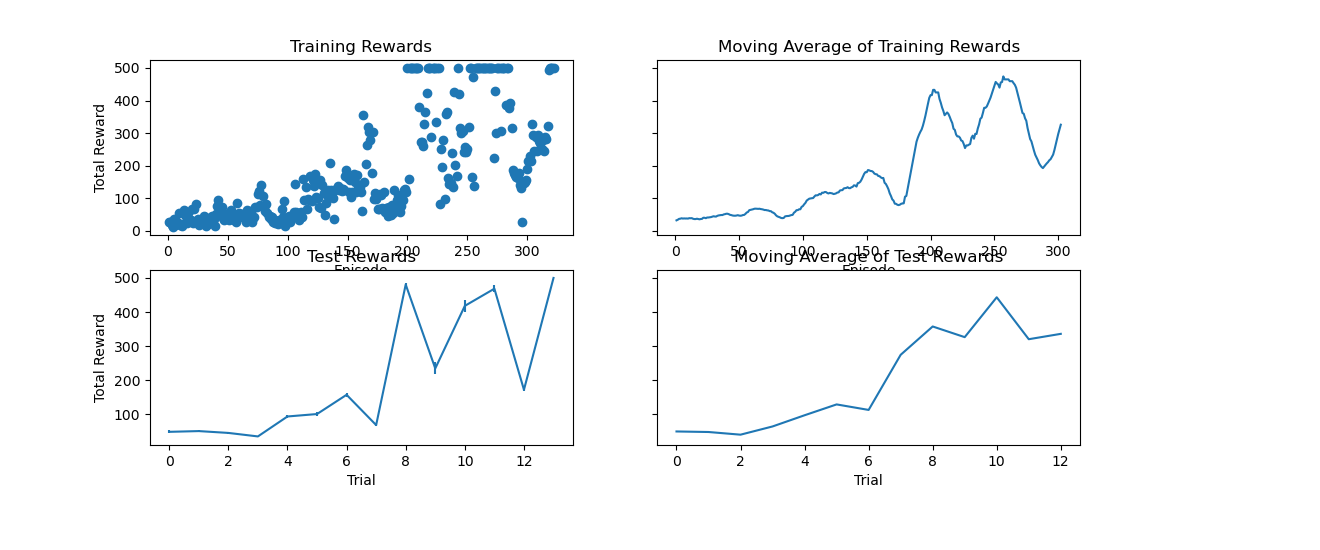

Solved at episode 323 in 5:52!


In [11]:
# %pylab inline
%matplotlib notebook

optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

rewards_list = []
test_rewards = []

start_time = time.time()

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
#             env.render() # Adding this line would show the attempts
            # of the agent in a pop up window.

            # These convert the state into a readable tensor
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0]) # store the critic value

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action])) # store the action probabilities

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)  # step
            rewards_history.append(reward)   # store reward
            episode_reward += reward   # add to total reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = alpha * episode_reward + (1 - alpha) * running_reward
        rewards_list.append(episode_reward)

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with discount
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:   # go through the list backwards
            discounted_sum = r + discount * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps) # add eps to avoid dividing by 0 j.i.c.
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns) # packages our lists together nicely (does nothing)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.

            # BASICALLY we look at how we did vs how we thought we would do (diff)...
            diff = ret - value
            # then we reward accordingly based on the probability that we chose that action
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            
            # This is simpler: just let it know what it should've been
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation: update the weights semi-manually
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 23 == 0:
        clear_output(wait=True)
        the_test_reward = tester(env)
        test_rewards.append(the_test_reward)
        cur_time = round(time.time() - start_time)
        m, leftover = divmod(cur_time, 60)
        tens, s = divmod(leftover, 10)
        template = "Current Running Reward: {:.2f} at Episode {} in {}:{}{}."
        clear_output()
        print(template.format(round(running_reward, prec), episode_count+1, m, tens, s))
        print("Current Test Reward: {}".format(round(np.mean(the_test_reward), prec)))
        
        FourGraphs()

        
        if np.mean(test_rewards[-1]) > 498:
            print("Solved at episode {} in {}:{}{}!".format(episode_count+1, m, tens, s))
            break
        
    if running_reward > 490 or np.mean(the_test_reward) == 500:  # Condition to consider the task solved
        print("Solved at episode {} in {}:{}{}!".format(episode_count+1, m, tens, s))
        break

In [15]:
final_test_list = []
for i in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        a,_,_ = select_action(s)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    final_test_list.append(total)
for _ in range(rendered_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        a,_,_ = select_action(s)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    final_test_list.append(total)
env.close()
low, sample_mean, high = confidence_interval_maker95(final_test_list)
print("Average Reward: {}".format(round(sample_mean, prec)))   # return average total score
print("The best trial had a reward of {}.".format(np.max(final_test_list)))
print("The worst trial had a reward of {}.".format(np.min(final_test_list)))
print("We have 95% confidence that the true average reward is between {} and {}.".format(low, high))
env.close()

Average Reward: 495.02
The best trial had a reward of 500.0.
The worst trial had a reward of 28.0.
We have 95% confidence that the true average reward is between 491.019 and 499.02.


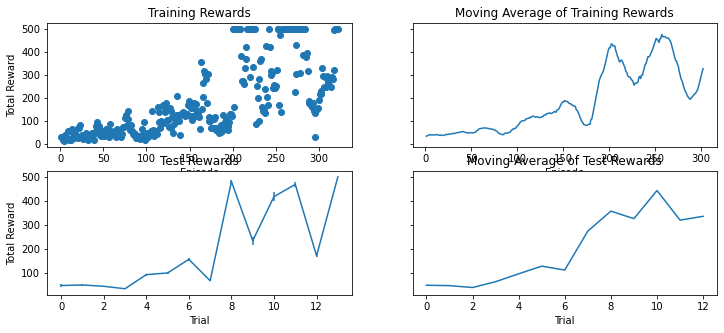

In [14]:
FourGraphs()